# Problem III

<b>Please create a simple machine learning pipeline</b> that will give user recommendation (1 user at least has 100 product recommendation) and save the recommendation to PostgreSQL using this <a href='https://nijianmo.github.io/amazon/index.html'>Amazon Dataset</a> and upload it in your github page. You will be grade not for the machine learning algorithm / model but for the pipeline performance (eg. processing time, no of data processed).

## Brief Introducttion
Recommendation systems have been widely used in product recommendations such as in Netflix, Amazon, Spotify, etc. In general, there are 2 methods for building a basic recommender systems:
1. Collaborative Filtering
2. Content-based Filtering

The method/algorithm I am going to use here is collaborative filtering. Collaborative filtering filters the interest of a user on a specific product by gathering/collecting information from other similar users.<br>
`If person A shares a similar opinion with person B, then person A is more likely to share person B's opinion on another issue than a random person`<br>
On the other hand, content-based filtering makes use of features/attributes to recommend products similar to the user liking based on other users' previous actions or explicit feedbacks.<br><br>

I will use the Amazon dataset provided from the link above, but i only use the 'Gift Cards' sub-dataset which contains about 147k rows for cheap and faster implementation. (The whole dataset is about 233.1 million records, which is roughly 34GB). Using the whole dataset would be too expensive, slower, and longer model training and implementation.

## Solution

### 1. Load and Preprocess Dataset
Since the dataset is in .gzip format, use gzip and json libraries from Python to load the dataset

In [25]:
import numpy as np
import pandas as pd
import gzip # read .gzip files
import json # take care of json formatted contents

In [26]:
def parse(path):
    """
    Read a .gzip file and parse its JSON contents
    
    # Arguments:
        path: string, absolute path to the dataset
        
    # Outputs:
        json_content: dict, the parsed JSON content
    
    """
    
    g = gzip.open(path, 'rb')
    for l in g:
        json_content = json.loads(l)
        
        yield json_content

def getDF(path):
    """
    Create a DataFrame from JSON content
    
    # Arguments:
        path: string, absolute path to the dataset
    
    # Returns:
        df: pandas.DataFrame, the loaded dataset in a DataFrame format
    
    """
    
    i = 0
    df = {}
    
    for d in parse(path):
        df[i] = d
    
        i += 1
      
    return pd.DataFrame.from_dict(df, orient='index')

In [49]:
# load dataset
df = getDF('data/Gift_Cards.json.gz')

print("Number of observations:", len(df))
print('First 5 rows:')
df.head()

Number of observations: 147194
First 5 rows:


,overall,vote,verified,reviewTime,reviewerID,asin,style,reviewerName,reviewText,summary,unixReviewTime,image
0,1.0,25,False,"12 19, 2008",APV13CM0919JD,B001GXRQW0,{'Gift Amount:': ' 50'},LEH,"Amazon,\nI am shopping for Amazon.com gift car...",Merry Christmas.,1229644800,NaN
1,5.0,NaN,False,"12 17, 2008",A3G8U1G1V082SN,B001GXRQW0,{'Gift Amount:': ' 50'},Tali,"I got this gift card from a friend, and it was...",Gift card with best selection,1229472000,NaN
2,5.0,4,False,"12 17, 2008",A11T2Q0EVTUWP,B001GXRQW0,{'Gift Amount:': ' 50'},Z,aren't we going to save trees?! :) People who ...,A convenient and great gift for the environmen...,1229472000,NaN
3,5.0,NaN,False,"12 17, 2008",A9YKGBH3SV22C,B001GXRQW0,{'Gift Amount:': ' 25'},Giotravels,You can always get someone something from Amaz...,Totally make sense,1229472000,NaN
4,1.0,NaN,True,"12 17, 2008",A34WZIHVF3OKOL,B001GXRQW0,NaN,King Dad,Why take 50 dollars of good money with no limi...,Give CASH!,1229472000,NaN


According to the official website, each column headers tell us about:
<ul>
    <li>reviewerID - ID of the reviewer, e.g. A2SUAM1J3GNN3B</li>
    <li>asin - ID of the product, e.g. 0000013714</li>
    <li>reviewerName - name of the reviewer</li>
    <li>vote - helpful votes of the review</li>
    <li>style - a disctionary of the product metadata, e.g., "Format" is "Hardcover"</li>
    <li>reviewText - text of the review</li>
    <li>overall - rating of the product</li>
    <li>summary - summary of the review</li>
    <li>unixReviewTime - time of the review (unix time)</li>
    <li>reviewTime - time of the review (raw)</li>
    <li>image - images that users post after they have received the product</li>
</ul>

Meanwhile, our workflow can be described as follows:
1. A user rates an item/a product
2. Ratings are considered as the user's level of interest/satisfaction on a specific item
3. The system will find similar ratings from differrent users against a user
4. Finally, the system recommends item(s) that have high ratings, but not yet rated by this user

Thus, according to the workflow above, we can conclude that `overall` and `reviewerName` are the only columns that have high impact in training our recommendation system model.

### 2. Explore and Analyze Dataset
Let's explore and analyze the data a little bit. `pandas` and `matplotlib` have provided some useful functions that I can utilize

In [48]:
import matplotlib.pyplot as plt

In [115]:
print("Number of unique customers in the dataset:", df['reviewerName'].nunique())
print("Number of unique products in the dataset:", df['asin'].nunique())

Number of unique customers in the dataset: 97693
Number of unique products in the dataset: 1548


Rating counts against the number of reviewers
5.0 stars: 126689 reviewers
4.0 stars: 8700 reviewers
1.0 stars: 7165 reviewers
3.0 stars: 2996 reviewers
2.0 stars: 1644 reviewers


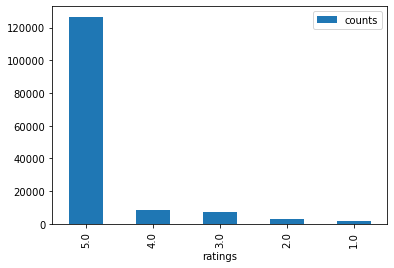

In [87]:
# count the number of customers who submit 1.0-5.0 stars rating
rating_dict = df['overall'].value_counts()

print('Rating counts against the number of reviewers')
for rating in rating_dict.keys():
    print('{} stars: {} reviewers'.format(rating, rating_dict[rating]))

# plot the results into bar plots
rating_df = pd.DataFrame({
    'ratings': [5.0, 4.0, 3.0, 2.0, 1.0],
    'counts': df['overall'].value_counts().values
})
rating_df.plot(kind='bar', x='ratings', y='counts')
plt.show()

In [93]:
df['year_reviewed'] = pd.to_datetime(df['unixReviewTime'], unit='s').dt.year

Customer count against the years the ratings are submitted
Year 2016: 33159 reviewers
Year 2015: 26927 reviewers
Year 2017: 25203 reviewers
Year 2014: 21934 reviewers
Year 2018: 18018 reviewers
Year 2013: 15250 reviewers
Year 2012: 5908 reviewers
Year 2011: 427 reviewers
Year 2010: 205 reviewers
Year 2009: 145 reviewers
Year 2008: 18 reviewers


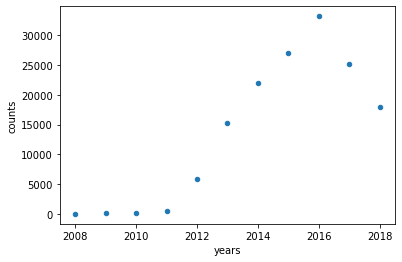

In [114]:
# count the number of customers who submit on a specific year
year_dict = df['year_reviewed'].value_counts()

print('Customer count against the years the ratings are submitted')
for year in year_dict.keys():
    print('Year {}: {} reviewers'.format(year, year_dict[year]))

# plot the results into bar plots
year_df = pd.DataFrame({
    'years': [year for year in year_dict.keys()],
    'counts': year_dict.values
})

year_df.plot(kind='scatter', x='years', y='counts')
plt.show()

In [28]:
df.describe()

,overall,unixReviewTime
count,147194.000000,1.471940e+05
mean,4.671970,1.447245e+09
std,0.955134,5.221619e+07
min,1.000000,1.228522e+09
25%,5.000000,1.409789e+09
50%,5.000000,1.453334e+09
75%,5.000000,1.485389e+09
max,5.000000,1.538266e+09


`object` data types can be in form of strings, lists, dictionaries, etc.

In [29]:
df.dtypes

overall           float64
vote               object
verified             bool
reviewTime         object
reviewerID         object
asin               object
style              object
reviewerName       object
reviewText         object
summary            object
unixReviewTime      int64
image              object
dtype: object

Since `overall` column tells us about user ratings, we have to make sure that there are no empty/NaN values.

In [30]:
print("Overall empty values count:", np.sum(pd.isnull(df['overall'])))

Overall empty values count: 0


Great, we can see that the output '0' means we have no empty values inside `overall` column.<br>
How about other columns?

In [31]:
# count how many empty values each column has
for c in df.columns:
    if c == 'overall':
        continue
    print("{} empty values count: {}".format(c, np.sum(pd.isnull(df[c]))))

vote empty values count: 140853
verified empty values count: 0
reviewTime empty values count: 0
reviewerID empty values count: 0
asin empty values count: 0
style empty values count: 104819
reviewerName empty values count: 4
reviewText empty values count: 159
summary empty values count: 40
unixReviewTime empty values count: 0
image empty values count: 146788


There are some empty/NaN values here and there. Since the only columns we care about are `overall` and `reviewerName`, we can drop them later.<br>
Nevertheless, it is a great common practice to fill any empty values with a default value (e.g. empty string `''`)

In [32]:
df = df.fillna('') # fill empty/NaN values with empty strings ('')
df = df.drop(['verified', 'reviewTime', 'unixReviewTime', 'vote', 'style', 'image'], axis=1) # drop unused columns

Let's check the final preprocessed and cleaned dataset

In [33]:
df.head()

,overall,reviewerID,asin,reviewerName,reviewText,summary
0,1.0,APV13CM0919JD,B001GXRQW0,LEH,"Amazon,\nI am shopping for Amazon.com gift car...",Merry Christmas.
1,5.0,A3G8U1G1V082SN,B001GXRQW0,Tali,"I got this gift card from a friend, and it was...",Gift card with best selection
2,5.0,A11T2Q0EVTUWP,B001GXRQW0,Z,aren't we going to save trees?! :) People who ...,A convenient and great gift for the environmen...
3,5.0,A9YKGBH3SV22C,B001GXRQW0,Giotravels,You can always get someone something from Amaz...,Totally make sense
4,1.0,A34WZIHVF3OKOL,B001GXRQW0,King Dad,Why take 50 dollars of good money with no limi...,Give CASH!


Looking good! We can proceed with the next step.<br>
Next, for flexibility purposes, I store all users along with their names and UIDs in a `dict` called 'users'. This `dict` will makes the prediction phase easier (which I will explain later)

In [34]:
users = {} # dict of users

# fill users dict according to their names and UIDs
for name,uid in zip(df['reviewerName'], df['reviewerID']):
    if name not in users:
        users[name] = uid

# display the first 20 users
for i, n in enumerate(df['reviewerName']):
    if i == 20:
        break
    print(n, users[n])
    

LEH APV13CM0919JD
Tali A3G8U1G1V082SN
Z A11T2Q0EVTUWP
Giotravels A9YKGBH3SV22C
King Dad A34WZIHVF3OKOL
D. Daniels A221J8EC5HNPY6
C. Michael Gamble A204VFHD6JWASO
MjSher A3QN3GMNS7NBIQ
D. Magilnick A1BXZIDZOMBAV2
P. Chung AJ7D8N3Z1Q7MK
joe A36UACIX4M8IVQ
Amazon Customer A5FEAOLPMWJQB
NICOLA CACCHIONE A14XDZ9HB51T1H
mom2girls A2UZS69NXZ1WW7
Cheyenne A2AB6HL83JZ1BO
Robert B. A21WZ65DFKQ5N8
Alexander Gimon A1VN7BM6Y5TQJA
Amazon Customer A5FEAOLPMWJQB
crystal lynn phelps A2CKVUNA97MJOU
Brenndy A7I9KD0PJAEAX


### 3. Model Training
We will use `scikit-surprise` to implement colaborative filtering and train our model

In [35]:
# Uncomment and run code below to install scikit-surprise
#!pip installl scikit-surprise

In [36]:
from surprise import Reader, Dataset, SVD
from surprise.model_selection.validation import cross_validate

In [37]:
reader = Reader() # content parser inside the dataset
data = Dataset.load_from_df(df[['reviewerID', 'asin', 'overall']], reader) # load our DataFrame 'df' dataset to be fed to the model
svd_model = SVD() # our model instance, built with SVD. We can also build different models like Probabilistic Matrix Factorization (PMF) or Non-negative Matrix Factorization (NMF)

`Reader()` class will parse the file containing users, products, and ratings.<br>
Once the model is ready, we can evaluate the model by implementing k-fold cross-validation.

In [38]:
# Run 5-fold cross-validation and print results
cross_validate(svd_model, data, measures=['RMSE', 'MAE'], cv=5, verbose=True)

Evaluating RMSE, MAE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.9245  0.9409  0.9331  0.9198  0.9244  0.9286  0.0075  
MAE (testset)     0.5387  0.5479  0.5428  0.5365  0.5360  0.5404  0.0045  
Fit time          4.99    5.07    5.00    5.08    5.06    5.04    0.04    
Test time         0.36    0.12    0.12    0.12    0.11    0.16    0.10    


{'test_rmse': array([0.92453012, 0.94089099, 0.9331198 , 0.91979584, 0.92442959]),
 'test_mae': array([0.53866103, 0.54794479, 0.54282242, 0.53646724, 0.53595096]),
 'fit_time': (4.993110179901123,
  5.070276498794556,
  4.999421119689941,
  5.0791003704071045,
  5.060134649276733),
 'test_time': (0.35735487937927246,
  0.11648249626159668,
  0.1170041561126709,
  0.1179506778717041,
  0.11491870880126953)}

We can also retrain our model with the entire training dataset

In [39]:
new_training_set = data.build_full_trainset()
svd_model.fit(new_training_set)

### 4. Model Prediction
Before we get into the predicting step, we need to load the metadata dataset because this dataset contains all products' name, description, brand, price, etc.

In [40]:
# load metadata dataset
metadata = getDF('data/meta_Gift_Cards.json.gz')

In [41]:
# shows top 5 rows
metadata.head()

,category,tech1,description,fit,title,also_buy,image,tech2,brand,feature,rank,also_view,details,main_cat,similar_item,date,price,asin
0,"[Gift Cards, Gift Cards]",,[Gift card for the purchase of goods or servic...,,Serendipity 3 $100.00 Gift Card,[],[],,Serendipity 3,[],[],[],{' Product Dimensions: ': '3.4 x 2.1 ...,Grocery,,,,B001BKEWF2
1,"[Gift Cards, Gift Cards]",,[Amazon.com Gift Cards are the perfect way to ...,,Amazon.com Gift Cards,[],[https://images-na.ssl-images-amazon.com/image...,,Amazon,[Amazon.com Gift cards never expire and carry ...,[],"[BT00DC6QU4, B01I4AHZXC, B0719C5P56, B01K8RLHZ...","{'Shipping Weight:': '0.5 ounces', 'Domestic S...",Gift Cards,,,,B001GXRQW0
2,"[Gift Cards, Gift Cards]",,"[<div class=""aplus""> <br>Amazon.com Gift Cards...",,"Amazon.com Gift Cards, Pack of 50 (Old Version...","[B005ESMEBQ, B007EE5WNA, B007EE5OBU, B07HJHK8Y...",[https://images-na.ssl-images-amazon.com/image...,,Amazon,"[Contains 50 Gift Cards, Gift Card has no fees...","1,786 in Gift Cards (","[B005ESMEBQ, B007EE5OBU, B007EE5WNA, B007EE60N...","{'Shipping Weight:': '1.8 pounds (', 'Domestic...",Gift Cards,,,"$1,250.00",B001H53QE4
3,"[Gift Cards, Gift Cards]",,"[<div class=""aplus""> <h4>Amazon.com Gift Cards...",,"Amazon.com $50 Gift Cards, Pack of 50 (Old Ve...",[],[https://images-na.ssl-images-amazon.com/image...,,Amazon,"[Contains 50 Gift Cards, Gift Card has no fees...",[],[],"{'Shipping Weight:': '1.6 pounds', 'Domestic S...",Gift Cards,,,,B001H53QEO
4,"[Gift Cards, Gift Cards]",,[],,Wood Puzzle Magic Box Gift Card,[],[https://images-na.ssl-images-amazon.com/image...,,Creative Crafthouse,[],"[>#2,893,775 in Toys & Games (See Top 100 in T...",[],{},Toys & Games,,,,B001KMWN2K


For simplicity, I only show the 'product ID' (asin) and 'product name' (title) in the prediction phase

In [42]:
metadata = metadata[['asin', 'title']] # extract only product id and product name
metadata.head()

,asin,title
0,B001BKEWF2,Serendipity 3 $100.00 Gift Card
1,B001GXRQW0,Amazon.com Gift Cards
2,B001H53QE4,"Amazon.com Gift Cards, Pack of 50 (Old Version..."
3,B001H53QEO,"Amazon.com $50 Gift Cards, Pack of 50 (Old Ve..."
4,B001KMWN2K,Wood Puzzle Magic Box Gift Card


Recall that I made a `dict` called 'users' in the beginning of this notebook and this is where it gets very useful. On training phase, the model only recognizes UID (users' ID) instead of names. Hence, when making a prediction, we also need to feed in the user ID. 'users' `dict` will make our job easier so that we can enter a name and it will find its corresponding ID

In [44]:
USER_NAME = 'D. Daniels' # user name
USER_ID = users[USER_NAME] # user ID

# append 'recommendation_score' column in order to a make prediction
metadata['recommendation_score'] = metadata['asin'].apply(lambda x: svd_model.predict(USER_ID, x).est)

In [45]:
num_of_recommendations_to_show = 100 # show top 100 recommendations
metadata = metadata.sort_values(by=['recommendation_score'], ascending=False) # sort by descending order (big to small recommendation_score)

print('Top {} Recommendations for {}:'.format(num_of_recommendations_to_show, USER_NAME))
recommendations = metadata.head(num_of_recommendations_to_show)
recommendations

Top 100 Recommendations for D. Daniels:


,asin,title,recommendation_score
1438,B0187SV7Y4,Amazon eGift Card - Dance (Animated),5.000000
137,B004LLILQY,Amazon eGift Card - Happy Kwanzaa,5.000000
1091,B00O4I5S7O,"Panera Bread Gift Cards, Multipack of 3",5.000000
345,B00AF0KAWI,Amazon.com Gift Card - Upload Your Photo (Pri...,5.000000
529,B00CRQ4XA8,Amazon Gift Card - Print - Happy Father&#39;s...,5.000000
...,...,...,...
201,B004RD9ACA,Amazon Gift Card - Print - Happy Birthday (Hats),4.852773
344,B00ADR2XIC,Amazon.com Gift Card in a White Gift Box (Clas...,4.849049
145,B004LLIL5A,Amazon eGift Card - Celebrate,4.848496
116,B004LLIL3C,Amazon eGift Card - Happy Birthday (Octopus),4.848088


### 5. Saving Prediction
Finally, save those predictions (recommendation list) into a Postgresql database. To do this, we need to install `psycopg2` library and setup a local database (https://www.postgresql.org/download/)

In [ ]:
# Uncomment and run this code below to install psycopg2 which can connect Python to Postgresql
#!pip install psycopg2

To make it more convenient, we can also make a configuration file to store connection parameters. In practice, developers often use `database.ini` which contains:

```
[postgresql]
host=localhost
database=db_name
user=postgres
password=admin
```

By doing this, we can change the configuration connection parameters when we move the code to production environment without making changes to the code

In [46]:
import psycopg2

def insert_recommendation_list(product_id_list, product_name_list):
    
    """
    Insert records (recommendation lists) into a Postgresql database
    
    # Arguments:
        product_id_list: list, a list of product IDs
        product_name_list: list, a list of product names
    
    # Outputs:
        None
    """
    
    # SQL INSERT query
    query = """INSERT INTO recommendations(product_id_list, product_name_list)
            VALUES(%s, %s)"""
    
    conn = None # set initial connection to null
    
    # initiate connection to database
    try:
        print('Connecting to database...')
        conn = psycopg2.connect(host='localhost', # local connection
                               database='kitabisa_db', # our DB name
                               user='admin', # username
                               password='k1t@B!$a') # password
        cur = conn.cursor()
        print('Inserting rows...')
        cur.execute(sql, (product_id_list, product_name_list)) # execute INSERT command
        conn.commit() # make changes to the database
        cur.close()
    
    # throw an error if connection to database cannot be initiated
    except(Exception, psycopg2.DatabaseError) as error:
        print(error)
    
    # close database connection
    finally:
        if conn is not None:
            print('Transaction completed, closing database connection...')
            conn.close()

In [47]:
insert_recommendation_list(recommendations['asin'].values.tolist(), recommendations['title'].values.tolist())